### PDZ Containing SwissProt Proteins

#### Description

The file `pdz_swissprot_af_full_id.txt` contains the names of all proteins that include a **PDZ domain** from the **Interpro SwissProt** database. This is **777** proteins. This file was obtained by running `download_pdz_swissprot.py` (script created by uniprot). The output listed protein names as *Q9Z2H7*, a simple command was run to change the names to contain **AF-** *Q9Z2H7* **-F1-model_v4** 

### Generation of list of PDZ containing domains found by Foldcomp

#### Description

To use foldcomp, we need a list of domains that in the foldcomp database. We need to check that all the structures in `pdz_swissprot_af_full_id.txt` are in the database before we run CIRPIN/Progres embed. 

#### Make a list of pdz_ids from the structure list provided by **Interpro Swissprot** 

In [ ]:
pdz_ids = []
with open('pdz_swissprot_af_full_id.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        pdz_id = line.strip()
        pdz_ids.append(pdz_id)

#### Check `/home/gridsan/akolodziej/Foldcomp/afdb_swissprot_v4` to find domains in the Foldcomp afdb_swissprot 

In [1]:
import foldcomp

In [ ]:
pdz_found = {}
with foldcomp.open("/home/gridsan/akolodziej/Foldcomp/afdb_swissprot_v4", ids = pdz_ids) as db:
    i =0
    for (name, pdb) in db:
        #print(name)
        pdz_found[name] = pdb
        #print(name)
        #print(pdb[:10])
        i += 1
    print(i)

#### Create new .txt of Foldcomp found swissprot proteins containing pdz domains

In [ ]:
found_pdzs = list(pdz_found.keys())
found_pdzs_noext = [os.path.splitext(os.path.basename(pdz))[0] for pdz in found_pdzs]

#### Save found swissprots to new file

`with open('foldcomp_found_pdz_swissprot_af_full_id.txt', 'a') as file:
    for i in found_pdzs_noext:
        file.write(i + '\n')`

#### Duplicate the column in the file to get correct format for CIRPIN/Progres

`awk '{print $0, $0}' foldcomp_found_pdz_swissprot_af_full_id.txt > foldcomp_found_pdz_swissprot_af_full_id_duplicate.txt` 

### Embedding PDZ Containing SwissProt Proteins

#### Description

The next step is to embed all the PDZ containing proteins using CIRPIN/Progres. CIRPIN/Progres has been modified to query alphafold structures in swissprot using **Foldcomp** and to parse each protein into domains by looking up boundaries using the **TED sqlite3 database**, which needs to be copied to the local disk of the compute node: `/state/partition1/user/akolodziej/lookup_ted_365M.db`

Look-up database are created for boundaries and for labels separately by:
`/home/gridsan/akolodziej/TED/tsv_sqlite.sh`
`/home/gridsan/akolodziej/TED/tsv_sqlite_2.sh`
`/home/gridsan/akolodziej/TED/tsv_sqlite.py`
`/home/gridsan/akolodziej/TED/tsv_sqlite_2.py`


Embedding the structures requires a list of structures from the Foldcomp database: **`foldcomp_found_pdz_swissprot_af_full_id_duplicate.txt`** 

The embeddings are saved to:

`/home/gridsan/akolodziej/PDZ_clean/embeddings/CIRPIN/`
`/home/gridsan/akolodziej/PDZ_clean/embeddings/Progres/`

In [2]:
import torch
import os
import matplotlib.pyplot as plt

/home/gridsan/akolodziej/.conda/envs/prog_mod/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# use prog_mod kernel
import sys
sys.path.append('/home/gridsan/akolodziej/progres_link')
import progres_foldcomp as pg
import CIRPIN_foldcomp as cpg

In [4]:
from tqdm import tqdm
import sqlite3

#### Embed all PDZ domains using CIRPIN
#####  - Checks if output already exists

In [ ]:

output_path = "/home/gridsan/akolodziej/PDZ_clean/embeddings/CIRPIN/pdz_swissprot_TED_domains_CIRPIN.pt"

if not os.path.exists(output_path):
    with tqdm(total=1, desc="Embedding progress") as pbar:
        cpg.CIRPIN_embed(
            "/home/gridsan/akolodziej/PDZ_clean/foldcomp_found_pdz_swissprot_af_full_id_duplicate.txt",
            output_path,
            fc=True
        )
        pbar.update(1)

#### Embed all PDZ domains using Progres
##### - Checks if output already exists

In [ ]:
output_path = "/home/gridsan/akolodziej/PDZ_clean/embeddings/Progres/pdz_swissprot_TED_domains_Progres.pt"

if not os.path.exists(output_path):
    with tqdm(total=1, desc="Embedding progress") as pbar:
        pg.progres_embed(
            "/home/gridsan/akolodziej/PDZ_clean/foldcomp_found_pdz_swissprot_af_full_id_duplicate.txt",
            output_path,
            fc=True
        )
        pbar.update(1)

### Load the embeddings

#### Description

These .pt objects are just dictionaries with the ids of the domains, their embeddings, nres, and notes

In [5]:
embeds_CIRPIN = torch.load('/home/gridsan/akolodziej/PDZ_clean/embeddings/CIRPIN/pdz_swissprot_TED_domains_CIRPIN.pt')

In [6]:
embeds_Progres = torch.load('/home/gridsan/akolodziej/PDZ_clean/embeddings/Progres/pdz_swissprot_TED_domains_Progres.pt')

### Isolate only the PDZ domains
#### Description

The embeddings thus far of are all the domains from PDZ containing proteins; there are lots of domains that are **NOT** PDZ domains. We need to filter out the embeddings that correspond to PDZ domains. 

To retrieve the CATH label for a domain, we made a *sqlite3* database: `/state/partition1/user/akolodziej/lookup_ted_365M_CATH.db` 

**Make sure you have this copied to the local disk on your compute node:** `/state/partition1/user/akolodziej/`

The other database created is for looking up domain boundaries and is 
`/state/partition1/user/akolodziej/lookup_ted_365M.db`


In [7]:
def get_cath(afdb_name):
    ''' Given afdb_name, returns the CATH label '''
    
    ### This database gives the CATH label for a given domain
    conn = sqlite3.connect('/state/partition1/user/akolodziej/lookup_ted_365M_CATH.db')
    cursor = conn.cursor()
    cursor.execute('SELECT cath FROM lookup_table WHERE name = ?', (afdb_name,))
    result = cursor.fetchone()
    conn.close()
    return result[0] if result else "Not found"

# Test it
#print(get_cath('AF-Q63622-F1-model_v4_TED03'))

def isolate_domains(embs, CATH_label):
    ''' Take a .pt of progres/cirpin embeddings (embs) and return only the ones that are for the domain of interest (CATH_label);
    i.e. filter for the domains you care about based on CATH label'''
    
    ids = embs['ids']
    
    # Target domain ex. PDZ domains
    target_domains = []
    
    for domain in ids:
        cath = get_cath(domain)
        if cath == CATH_label:
            target_domains.append(domain)
    
    
    # List of IDs to remove
    keep_ids = set(target_domains)  # Using a set for faster lookups

    # Get indices of IDs to keep
    keep_indices = [i for i, id_ in enumerate(embs["ids"]) if id_ in keep_ids]

# Filter dictionary based on indices

    target_data_only = {
    "ids": [embs["ids"][i] for i in keep_indices],  # Filter IDs
    "embeddings": embs["embeddings"][keep_indices],  # Filter tensor rows
    "nres": [embs["nres"][i] for i in keep_indices],  # Filter nres
    "notes": [embs["notes"][i] for i in keep_indices],  # Filter notes
}

    return target_data_only

### Get PDZ only from the PDZ containing protein embeddings

In [8]:
# Define PDZ CATH label
PDZ_CATH = '2.30.42.10'

### Finally, get the embeddings for only the PDZ domains from swissprot

In [9]:
#Progres
pdz_ONLY_swissprot_TED_domains_Progres = isolate_domains(embeds_Progres, PDZ_CATH)
#CIRPIN
pdz_ONLY_swissprot_TED_domains_CIRPIN = isolate_domains(embeds_CIRPIN, PDZ_CATH)


In [10]:
print('Total number of swissprot PDZ domains isolated:', len(pdz_ONLY_swissprot_TED_domains_CIRPIN['ids']))

Total number of swissprot PDZ domains isolated: 1191


### Save embeddings for PDZ only domains from swissprot

In [11]:
pdz_only_output_path = "/home/gridsan/akolodziej/PDZ_clean/embeddings/Progres/pdz_ONLY_swissprot_TED_domains_Progres.pt"

if not os.path.exists(pdz_only_output_path):
    torch.save(pdz_ONLY_swissprot_TED_domains_Progres, "/home/gridsan/akolodziej/PDZ_clean/embeddings/Progres/pdz_ONLY_swissprot_TED_domains_Progres.pt")


In [12]:
pdz_only_output_path = "/home/gridsan/akolodziej/PDZ_clean/embeddings/CIRPIN/pdz_ONLY_swissprot_TED_domains_CIRPIN.pt"

if not os.path.exists(pdz_only_output_path):
    torch.save(pdz_ONLY_swissprot_TED_domains_CIRPIN, "/home/gridsan/akolodziej/PDZ_clean/embeddings/CIRPIN/pdz_ONLY_swissprot_TED_domains_CIRPIN.pt")


### Download PDZ domains from Foldcomp
#### At this point there are isolated PDZ domains; the functions below retrieves these pdbs for TM-align use

In [81]:
########## Create pdb files of PDZ domains for tm-align comparison

### Input: pdz_ids_progres list of pdz ids: ex. AF-A3LX99-F1-model_v4_TED06. filepath_dir: '/home/gridsan/akolodziej/TED/pdz_swissprot_pdbs/pdz_individual_domains'

### Checks first to see if the pdb file exists already
from pdbtools.pdb_selres_str import select_residues_from_string

def convert_boundaries(input_str):
    ''' convert boundary str from foldcomp to one that works for pdbtools'''
    # Replace underscores with commas and hyphens with colons
    result = input_str.replace('_', ',').replace('-', ':')
    return result 

def get_boundaries(name):
    conn = sqlite3.connect('/state/partition1/user/akolodziej/lookup_ted_365M.db')
    cursor = conn.cursor()
    cursor.execute('SELECT boundaries FROM lookup_table WHERE name = ?', (name,))
    result = cursor.fetchone()
    conn.close()
    return result[0] if result else "Not found"

def download_ted_domains(domain_list):
    log_path = "/home/gridsan/akolodziej/PDZ_clean/PDZ_pdbs/ted_download_log.txt"
    ### Loop through TED domains
    for name in domain_list:
        
        ## Get boundaries
        boundaries = get_boundaries(name)
        pdb_bounds = convert_boundaries(boundaries)
        ## Get name without TED suffix to query from Foldcomp db    
        name_remove_ted = name.split("v4", 1)[0] + "v4"
        basenames = [name_remove_ted]
        # Get PDB for the basename    
        with foldcomp.open("/home/gridsan/akolodziej/Foldcomp/afdb_swissprot_v4", ids = basenames) as db: 
            pdb = db[0][1]
            ted_pdb = select_residues_from_string(pdb, pdb_bounds)
            output_pdb_path = f'/home/gridsan/akolodziej/PDZ_clean/PDZ_pdbs/{name}.pdb'
            # Write the TED pdb to a new file
            if not os.path.exists(output_pdb_path):
                with open(output_pdb_path, "w") as f:
                    f.write(ted_pdb)
                # Update the first line to match the filenmae title
                with open(output_pdb_path, "r") as file:
                    lines = file.readlines()
                    # Update the first line to match the filename
                    if lines:
                        lines[0] = f"TITLE     {name}.pdb\n"
                    # Write the modified lines back to the same file
                    with open(output_pdb_path, "w") as file:
                        file.writelines(lines)
                with open(log_path, "a") as log_file:
                    log_file.write(f"Made file {name}\n")
            



In [82]:
pdz_ids_progres = list(pdz_ONLY_swissprot_TED_domains_Progres['ids'])

In [83]:
### DOWNLOAD PDZ DOMAINS

In [84]:
download_ted_domains(pdz_ids_progres)

### Plot PCA of Progres and CIRPIN PDZ embeddings

In [13]:
from sklearn.decomposition import PCA

### Create new ids_embs dictionary

The dictionary from Progres has the ids as values of key "ids" and the embeddings and values of 'embeddings'.

Making a new dictionary that maps id (key) to embedding (value) for downstream use

In [14]:
pdz_ids_progres = list(pdz_ONLY_swissprot_TED_domains_Progres['ids'])

# New id:embs dictionary
id_embs_prog = {}

for i in pdz_ids_progres:
    idx = pdz_ONLY_swissprot_TED_domains_Progres['ids'].index(i)
    id_embs_prog[i] = pdz_ONLY_swissprot_TED_domains_Progres['embeddings'][idx]
    

pdz_ids_CIRPIN = list(pdz_ONLY_swissprot_TED_domains_CIRPIN['ids'])

# New id:embs dictionary
id_embs_CIRPIN = {}

for i in pdz_ids_CIRPIN:
    idx = pdz_ONLY_swissprot_TED_domains_CIRPIN['ids'].index(i)
    id_embs_CIRPIN[i] = pdz_ONLY_swissprot_TED_domains_CIRPIN['embeddings'][idx]


### Create new ids_topology dictionary

Need a dictionary that maps ids to one of 'gem' topologies (three PDZ topologies).
Constructing this dictionary to be able to color the PCA plots below by PDZ topology.

In [15]:
sys.path.append('/home/gridsan/akolodziej/TM_tools/')
from TM_utils import TM_align 
from TM_utils import TM_score

#### Define paths to `gems` and `pdz domains`

In [16]:
pdz_domains = '/home/gridsan/akolodziej/TED/pdz_swissprot_pdbs/pdz_individual_domains'
gems = '/home/gridsan/akolodziej/pdbscratch/pdz/gems'

### Get the corresponding 'gem' classification (topology) for each PDZ domain

In [121]:
from pathlib import Path
from collections import defaultdict
import pickle
def analyze_pdz_domains(pdz_list, pdz_domains_dir, gems_dir):
    """
    Analyze PDZ domains by scoring against gems and tracking highest scoring matches.
    
    Args:
        pdz_list (list): list of PDZ domains to score
        pdz_domains_dir (str): Directory containing PDZ domain PDB files
        gems_dir (str): Directory containing GEM PDB files
    
    Returns:
        tuple: (best_matches_dict, gem_frequencies_dict)
    """
    # Initialize data structures
    best_matches = {}
    gem_frequencies = defaultdict(int)
    
    # Get lists of PDZ domains and gems
    #pdz_domains_list = [f for f in os.listdir(pdz_domains_dir) if f.endswith('.pdb')]
    pdz_domains_list = [ d + '.pdb' for d in pdz_list]
    gems_list = [f for f in os.listdir(gems_dir) if f.endswith('.pdb')]
    
    # Iterate through each PDZ domain
    i = 0
    for pdz_domain in pdz_domains_list:
        pdz_domain_path = os.path.join(pdz_domains_dir, pdz_domain)
        
        ### Check if pdz_domain_path exists, if it doesn't skip for now 
        if not os.path.exists(pdz_domain_path):
        # Skip this domain if the path doesn't exist
            print(f'{pdz_domain_path} doesnt exist')
            continue
        
        ### WRITE CODE THAT INSTEAD OF SKIPPING DOWNLOADS THE PROTEIN AND PARSES THE DOMAIN
        if (i % 100)== 0:
            print(i)
        i+=1
        # Track best score and best gem for this domain
        best_score = float('-inf')
        best_gem = None
        
        # Score against each gem
        for gem_file in gems_list:
            gem_path = os.path.join(gems_dir, gem_file)
            
            # Compute TM-align score
            score = TM_align(pdz_domain_path, gem_path, cp=False)
            if not score:
                print("Error: no TM_align score calculated, setting to 0")
                print(f'Problem paths: {pdz_domain_path}, {gem_path}')
                single_score = 0
            #print(score)
            else:
                #single_score = list(score.values())[0]
                single_score = max(list(score.values()))
            # Update best match if current score is higher
            if single_score > best_score:
                best_score = single_score
                best_gem = gem_file
        
        # Store best match
        if best_gem:
            best_matches[pdz_domain] = best_gem
            gem_frequencies[best_gem] += 1
    
    return best_matches, dict(gem_frequencies)


pdz_domains_path = '/home/gridsan/akolodziej/PDZ_clean/PDZ_pdbs'
gems_path = '/home/gridsan/akolodziej/PDZ_clean/PDZ_gems'

best_matches, gem_frequencies = analyze_pdz_domains(pdz_ids_progres, pdz_domains_path, gems_path)

0
100
200
300
400
500
600
700
800
900
1000
1100


### Print out summary results of the PDZ domain grouping

In [122]:
for gem, frequency in sorted(gem_frequencies.items(), key=lambda x: x[1], reverse=True):
    print('Gem Frequencies')
    print(f"{gem}: {frequency}")

#Save results
if not os.path.exists('/home/gridsan/akolodziej/PDZ_clean/PDZ_tm_align_results.pkl'):  
    with open('/home/gridsan/akolodziej/PDZ_clean/PDZ_tm_align_results.pkl', 'wb') as f:
        pickle.dump(best_matches, f)
if not os.path.exists('/home/gridsan/akolodziej/PDZ_clean/PDZ_tm_align_gem_frequencies.pkl'):
    with open('/home/gridsan/akolodziej/PDZ_clean/PDZ_tm_align_gem_frequencies.pkl', 'wb') as f:
        pickle.dump(gem_frequencies, f)


Gem Frequencies
1gm1_pdz.pdb: 811
Gem Frequencies
2z9i_pdz.pdb: 340
Gem Frequencies
2hga_pdz_trunc.pdb: 40


### Get embeddings from the dictionaries

In [123]:
progres_data = torch.stack([id_embs_prog[k] for k in pdz_ids_progres])  # Shape: (N, 128)
CIRPIN_data = torch.stack([id_embs_CIRPIN[k] for k in pdz_ids_CIRPIN])  # Shape: (N, 128)

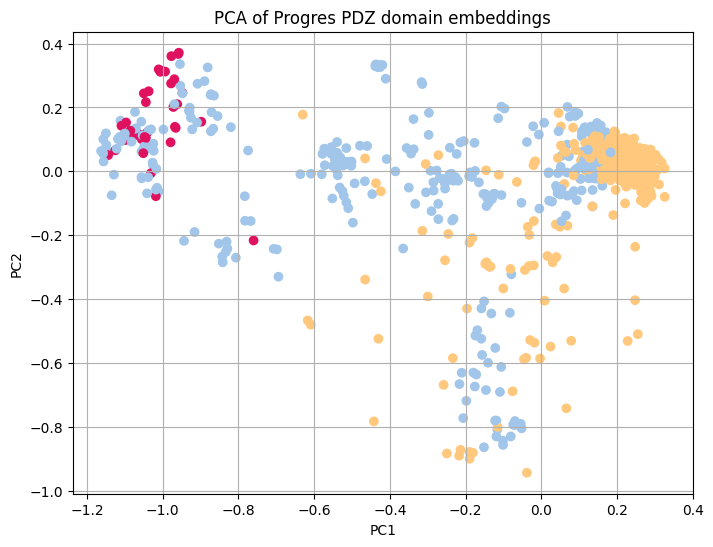

In [124]:
# Step 2: PCA to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(progres_data.numpy())


unique_groups = list(set(best_matches.values()))  # Get unique group labels
group_colors = ['#E0115F', '#A1C6EA', '#FFC87C']
                # Ruby,       Opal,      Topaz colors
color_map = {group: group_colors[i % len(group_colors)] for i, group in enumerate(unique_groups)}  # Create a color map
colors = [color_map[list(best_matches.values())[i]] for i in range(len(progres_data))]
          
# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors)

### Colors the datapoints according to the values in the dictionary `best_matches`

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Progres PDZ domain embeddings')
plt.grid(True)
plt.savefig('/home/gridsan/akolodziej/PDZ_clean/figures/PDZ_progres_PCA.png')
plt.show()

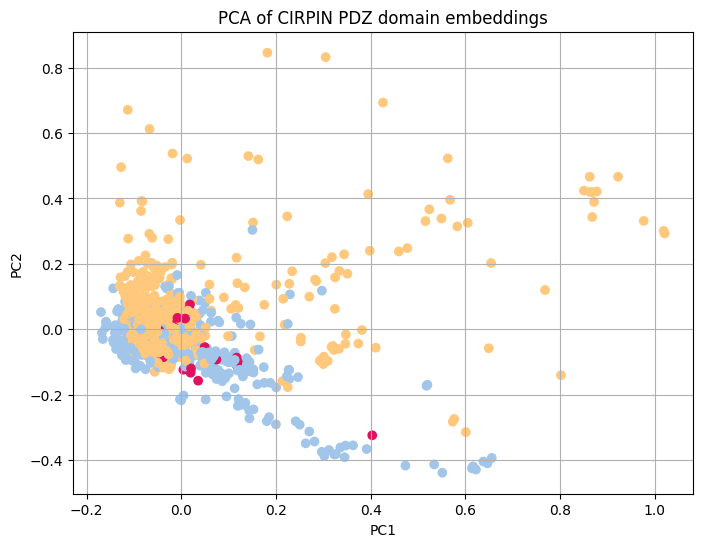

In [125]:
# Step 2: PCA to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(CIRPIN_data.numpy())

unique_groups = list(set(best_matches.values()))  # Get unique group labels
group_colors = ['#E0115F', '#A1C6EA', '#FFC87C']
                # Ruby,       Opal,      Topaz colors
color_map = {group: group_colors[i % len(group_colors)] for i, group in enumerate(unique_groups)}  # Create a color map
colors = [color_map[list(best_matches.values())[i]] for i in range(len(progres_data))]

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors)

### Colors the datapoints according to the values in the dictionary `best_matches`

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of CIRPIN PDZ domain embeddings')
plt.grid(True)
plt.savefig('/home/gridsan/akolodziej/PDZ_clean/figures/PDZ_CIRPIN_PCA.png')
plt.show()

### Highlight outliers

In [160]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 2: PCA to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(CIRPIN_data.numpy())

# Z-score to identify outliers
z_scores = np.abs(zscore(pca_result))
outlier_mask = (z_scores > 5).any(axis=1)  # Mark points with any PC score > 3 std devs away

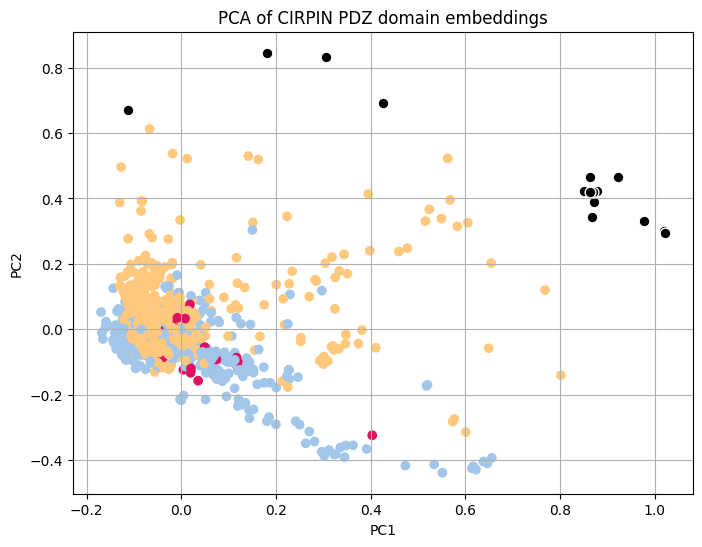

In [161]:
# Get unique group labels and colors
unique_groups = list(set(best_matches.values()))
group_colors = ['#E0115F', '#A1C6EA', '#FFC87C']
color_map = {group: group_colors[i % len(group_colors)] for i, group in enumerate(unique_groups)}
colors = [color_map[list(best_matches.values())[i]] for i in range(len(progres_data))]

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[~outlier_mask, 0], pca_result[~outlier_mask, 1], 
            c=np.array(colors)[~outlier_mask], label='Inliers')
plt.scatter(pca_result[outlier_mask, 0], pca_result[outlier_mask, 1], 
            c='black', edgecolor='white', label='Outliers', marker='o', s=60)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of CIRPIN PDZ domain embeddings')
plt.grid(True)
#plt.legend()
plt.savefig('/home/gridsan/akolodziej/PDZ_clean/figures/PDZ_CIRPIN_PCA_outliers.png')
plt.show()

### Get outlier indices to retrieve their structures

In [162]:
outlier_indices = []

idx = 0
for i in outlier_mask:
    if i:
        outlier_indices.append(idx)
    idx +=1

In [168]:
outlier_indices

[29, 159, 233, 235, 237, 239, 241, 265, 266, 441, 452, 770, 935, 1086, 1176]

In [174]:
pdz_outliers = [pdz_ids_progres[i] for i in outlier_indices]

In [175]:
pdz_outliers

['AF-A4D2P6-F1-model_v4_TED03',
 'AF-G5EDB9-F1-model_v4_TED03',
 'AF-O62674-F1-model_v4_TED01',
 'AF-O62675-F1-model_v4_TED01',
 'AF-O62676-F1-model_v4_TED01',
 'AF-O62677-F1-model_v4_TED01',
 'AF-O62678-F1-model_v4_TED01',
 'AF-O75970-F1-model_v4_TED06',
 'AF-O75970-F1-model_v4_TED07',
 'AF-Q0V8R5-F1-model_v4_TED01',
 'AF-Q12959-F1-model_v4_TED04',
 'AF-Q80YA9-F1-model_v4_TED01',
 'AF-Q969H4-F1-model_v4_TED01',
 'AF-Q9P202-F1-model_v4_TED03',
 'AF-Q9Z1T4-F1-model_v4_TED01']